In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import sklearn.svm
import cv2
from matplotlib import pyplot as plt
import numpy as np
from os.path import exists
import pandas as pd
import PIL
import torch
torch.cuda.empty_cache()
#cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
#accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

#print("Accelerator type = ",accelerator)
#print("Pytorch verision: ", torch.__version__)

In [ ]:
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_path = '/content/drive/My Drive/cars_latest/train_set/Training_cr.jpg'
test_path = '/content/drive/My Drive/Textile/data/test_set'
train_label = '/content/drive/My Drive/cars_latest/train_set/DL_cars_csv.csv'
test_label = '/content/drive/My Drive/cars_latest/validation_set/DL_cars_valid_csv.csv'

In [ ]:
list_upper = [1,5,7,9,12,13,15,17]
list_mid = [2,3,4,6,8,10,11,14,16]
list_end = [18,19,20,21,22,23,24,25]
list_full = [list_upper,list_mid,list_end]

In [ ]:
import ast

def get_car_labels_coordinates(input_file_path):
  label_file = pd.read_csv(input_file_path)

  polygon_coord  = label_file['region_shape_attributes']
  print(polygon_coord[0])
#  for key, value in polygon_coord.items():


  x_cord = ast.literal_eval(polygon_coord[0])['all_points_x']
  y_cord = ast.literal_eval(polygon_coord[0])['all_points_y']

  #print(x_cord)



  return polygon_coord

In [ ]:
def rows_col_pixels(index,rr,cc):
  if index+1 in list_upper:
    rr_new = rr+ 180
    cc_new = cc+ 180
  elif index+1 in list_mid:
    rr_new = rr+ 100
    cc_new = cc+ 100
  elif index+1 in list_end:
    rr_new = rr- 100
    cc_new = cc- 100

  return rr_new,cc_new

In [ ]:
from skimage.draw import polygon

def get_segmentation_mask_single(input_image_path,polygon_coord,index_list):
  image_color = cv2.imread(input_image_path)
  image_grayscale = cv2.cvtColor(image_color, cv2.COLOR_BGR2GRAY)
  image_color_rgb = cv2.cvtColor(image_color, cv2.COLOR_BGR2RGB)
  
  #plt.imshow(image_color)

  rr_list = []
  cc_list = []
  rr_new_list = []
  cc_new_list = []

  mask = np.zeros(image_grayscale.shape,dtype=np.uint8)
  mask3 = np.zeros(image_grayscale.shape,dtype=np.uint8)
  mask2 = image_color_rgb.copy()

  for index in index_list:
    rr, cc = polygon(np.array(ast.literal_eval(polygon_coord[index])['all_points_y']),np.array(ast.literal_eval(polygon_coord[index])['all_points_x']))
    #rr_list.append(rr)
    #cc_list.append(cc)
    rr_new,cc_new = rows_col_pixels(index,rr,cc)
    #rr_new_list.append(rr_new)
    #cc_new_list.append(cc_new)

    mask2[rr,cc] = image_color_rgb[rr_new,cc_new]
    mask2[rr_new,cc_new] = image_color_rgb[rr,cc]

    rgb_batch = np.repeat(mask2[..., np.newaxis], 3, -1)


    mask3[rr_new,cc_new] = 1
  '''
  plt.figure(1)
  plt.imshow(image_grayscale,cmap='gray')
  plt.figure(2)
  plt.imshow(mask2,cmap='gray')
  plt.figure(3)
  plt.imshow(mask3,cmap='gray')
  '''
  rgb_batch = np.repeat(mask2[..., np.newaxis], 3, -1)


  return mask2, mask3

In [ ]:
from skimage.draw import polygon

def get_segmentation_mask_valid(input_image_path,polygon_coord,index_list):
  image_color = cv2.imread(input_image_path)
  image_grayscale = cv2.cvtColor(image_color, cv2.COLOR_BGR2GRAY)
  image_color_rgb = cv2.cvtColor(image_color, cv2.COLOR_BGR2RGB)
  
  #plt.imshow(image_color)

  rr_list = []
  cc_list = []
  rr_new_list = []
  cc_new_list = []

  mask3 = np.zeros(image_grayscale.shape,dtype=np.uint8)
  mask2 = image_color_rgb.copy()

  for index in index_list:
    rr, cc = polygon(np.array(ast.literal_eval(polygon_coord[index])['all_points_y']),np.array(ast.literal_eval(polygon_coord[index])['all_points_x']))

    mask3[rr,cc] = 1
  '''
  plt.figure(1)
  plt.imshow(image_grayscale,cmap='gray')
  plt.figure(2)
  plt.imshow(mask2,cmap='gray')
  plt.figure(3)
  plt.imshow(mask3,cmap='gray')
  '''

  rgb_batch = np.repeat(mask2[..., np.newaxis], 3, -1)


  return mask2, mask3

In [ ]:
from skimage.draw import polygon

def get_segmentation_mask_multiple(input_image_path,polygon_coord,index_list):
  image_color = cv2.imread(input_image_path)
  image_grayscale = cv2.cvtColor(image_color, cv2.COLOR_BGR2GRAY)
  image_color_rgb = cv2.cvtColor(image_color, cv2.COLOR_BGR2RGB)

  #plt.imshow(image_color)

  rr_list = []
  cc_list = []
  rr_new_list = []
  cc_new_list = []

  mask = np.zeros(image_grayscale.shape,dtype=np.uint8)
  mask3 = np.zeros(image_grayscale.shape,dtype=np.uint8)
  mask2 = image_color_rgb.copy()

  for index in index_list:
    rr, cc = polygon(np.array(ast.literal_eval(polygon_coord[index-1])['all_points_y']),np.array(ast.literal_eval(polygon_coord[index-1])['all_points_x']))
    #rr_list.append(rr)
    #cc_list.append(cc)
    rr_new,cc_new = rows_col_pixels(index-1,rr,cc)
    #rr_new_list.append(rr_new)
    #cc_new_list.append(cc_new)

    mask2[rr,cc] = image_color_rgb[rr_new,cc_new]
    mask2[rr_new,cc_new] = image_color_rgb[rr,cc]

    rgb_batch = np.repeat(mask2[..., np.newaxis], 3, -1)




    mask3[rr_new,cc_new] = 1
  '''
  plt.figure(1)
  plt.imshow(image_grayscale,cmap='gray')
  plt.figure(2)
  plt.imshow(mask2,cmap='gray')
  plt.figure(3)
  plt.imshow(mask3,cmap='gray')
  '''

  return mask2, mask3

In [ ]:
polygon_coord_train = get_car_labels_coordinates(train_label)
polygon_coord_valid = get_car_labels_coordinates(test_label)


{"name":"polygon","all_points_x":[340,396,413,436,434,371,349],"all_points_y":[38,97,100,76,60,3,15]}
{"name":"polygon","all_points_x":[277,369,371,365,277,272],"all_points_y":[98,99,75,54,52,77]}


In [ ]:
print(len(polygon_coord_valid))

95


In [ ]:
mask, mask3= get_segmentation_mask_multiple(train_path,polygon_coord_train,[2])

In [ ]:
import os
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from skimage import io, transform,data
from torchvision import transforms, utils
import numpy as np
import math
from matplotlib.patches import Ellipse
from skimage.draw import ellipse
import glob
import random
import torchvision.transforms.functional as TF

class CarData(Dataset):
  def __init__(self, root_dir,polygon_coord_train,polygon_coord_valid,train=True,test=False, transform=None,transform_test=None):
    self.root_dir = root_dir
    self.root_dir_train = root_dir + '/train_set/Training_cr.jpg'
    self.root_dir_test = root_dir + '/test_set/test_set/Testset_10m_4.jpg'
    self.labels_path = self.root_dir+'/train_set/DL_cars_csv.csv'
    self.train = train
    self.polygon_coord_train = polygon_coord_train
    self.polygon_coord_valid = polygon_coord_valid

    #self.transform = transform
    self.transform_test = transform_test

    self.test = test

  def __len__(self):
    if self.train==True:
      #polygon_coord = get_car_labels_coordinates(self.labels_path)
      len1 = 230

#      return len(polygon_coord)
      return len1

    else:

      return 1   

  def transform(self, image, mask,test=False):
      #preprocessor = transforms.Compose([transforms.ToTensor(),resize, transforms.RandomHorizontalFlip(),transforms.RandomVerticalFlip(),transforms.RandomRotation(45),transforms.RandomPerspective(), transforms.RandomAffine(degrees=20),normalize])
      normalize = transforms.Normalize(mean = [0.485,0.456,0.406],
                              std = [0.229,0.224,0.225])
      # Transform to tensor
      image = TF.to_tensor(image)
      mask = TF.to_tensor(mask)

      # Resize
      resize = transforms.Resize(size=(512, 512))
      image = resize(image)
      mask = resize(mask)

      if test==True:
        #image = normalize(image)

        return image,mask


      # Random horizontal flipping
      if random.random() > 0.5:
          image = TF.rotate(image,45)
          mask = TF.rotate(mask,45)

      
      # Random horizontal flipping
      if random.random() > 0.5:
          image = TF.hflip(image)
          mask = TF.hflip(mask)

      # Random vertical flipping
      if random.random() > 0.5:
          image = TF.vflip(image)
          mask = TF.vflip(mask)

      
      #image = normalize(image)


      return image, mask




  def __getitem__(self,index):
    #index+=1
    #index = index%400
    if torch.is_tensor(index):
      index = index.tolist()
    #print(index)

    if self.train==True:
      try:
        img_name = self.root_dir_train
      except FileNotFoundError:
        pass
    else:
      try:
        img_name = self.root_dir_test

      except FileNotFoundError:
        pass

    #print(img_name)
    #print(ok)
    image = io.imread(img_name,as_gray=False)
    #print(image.shape)

    #print('Index',index)
    if self.train==False:
      #new_image,new_image_mask = get_segmentation_mask_valid(self.root_dir_test,self.polygon_coord_valid,list(range(len(polygon_coord_valid))))
      new_image = image.copy()

      if self.transform_test:
        #new_image,new_image_mask = self.transform(new_image,new_image_mask,test=True)
        new_image = self.transform_test(new_image)

      #sample = {'image': new_image, 'segmented_mask': new_image_mask}

      return new_image

    
    if index<25:
      new_image,new_image_mask = get_segmentation_mask_single(self.root_dir_train,self.polygon_coord_train,[index])

    elif index>24 and index<75:
      list_ch = random.sample([0,1,2], 1)
      list_select = list_full[list_ch[0]]
      random_index1 = random.sample(list_select, 2)
      new_image,new_image_mask = get_segmentation_mask_multiple(self.root_dir_train,self.polygon_coord_train,random_index1)
    
    elif index>74 and index<125:
      list_ch = random.sample([0,1,2], 1)
      list_select = list_full[list_ch[0]]
      random_index1 = random.sample(list_select, 4)
      new_image,new_image_mask = get_segmentation_mask_multiple(self.root_dir_train,self.polygon_coord_train,random_index1)

    elif index>124 and index<175:
      list_ch = random.sample([0,1,2], 1)
      list_select = list_full[list_ch[0]]
      random_index1 = random.sample(list_select, 6)
      new_image,new_image_mask = get_segmentation_mask_multiple(self.root_dir_train,self.polygon_coord_train,random_index1)

    elif index>174 and index<225:
      list_ch = random.sample([0,1,2], 1)
      list_select = list_full[list_ch[0]]
      random_index1 = random.sample(list_select, 8)
      new_image,new_image_mask = get_segmentation_mask_multiple(self.root_dir_train,self.polygon_coord_train,random_index1)

    elif index>224:
      list_ch = random.sample([0,1,2], 1)
      list_select = list_full[list_ch[0]]
      random_index1 = random.sample(list_select, 8)
      new_image,new_image_mask = get_segmentation_mask_valid(self.root_dir_train,self.polygon_coord_train,list(range(len(polygon_coord_train))))

#    if self.transform:
  
    new_image,new_image_mask = self.transform(new_image,new_image_mask)



    sample = {'image': new_image, 'segmented_mask': new_image_mask}

    #print(sample['label'])
    #plt.imshow(sample['image'])
    #plt.show()

    return sample

In [ ]:
#Pre processing the data
normalize = transforms.Normalize(mean = [0.485,0.456,0.406],
                                std = [0.229,0.224,0.225])
resize = transforms.Resize((512,512))
centrecrop = transforms.CenterCrop((224,224))
preprocessor = transforms.Compose(
    [transforms.ToTensor(),resize, transforms.RandomHorizontalFlip(),transforms.RandomVerticalFlip(),transforms.RandomRotation(45),transforms.RandomPerspective(), transforms.RandomAffine(degrees=20),normalize])
#minority_preprocessor = transforms.Compose([ transforms.ToTensor(),resize,transforms.RandomHorizontalFlip(), transforms.RandomRotation(45),transforms.RandomVerticalFlip(), transforms.RandomPerspective(), transforms.RandomAffine(degrees=20), transforms.RandomResizedCrop(224),normalize
#                                   ])

minority_preprocessor = transforms.Compose([ transforms.ToTensor(),resize, transforms.RandomHorizontalFlip(),transforms.RandomVerticalFlip(),transforms.RandomRotation(45),transforms.RandomPerspective(), transforms.RandomAffine(degrees=20),normalize
                                   ])


#preprocessor = transforms.Compose(
#    [transforms.ToTensor(),resize, transforms.RandomHorizontalFlip(),transforms.RandomVerticalFlip(),transforms.RandomRotation(45),transforms.RandomPerspective(), transforms.RandomAffine(degrees=20)])

preprocessor_test = transforms.Compose([ transforms.ToTensor(),resize
                                   ])

print(preprocessor.transforms[-1])

train_dataset_full = CarData(root_dir='/content/drive/My Drive/cars_latest',polygon_coord_train=polygon_coord_train,polygon_coord_valid=polygon_coord_valid, train=True,test=False, transform=preprocessor)
test_dataset_full = CarData(root_dir='/content/drive/My Drive/cars_latest',polygon_coord_train=polygon_coord_train,polygon_coord_valid=polygon_coord_valid, train=False,test=False, transform=preprocessor,transform_test=preprocessor_test)
'''
print(len(train_dataset_full))

train_split = 0.8
dataset_size  = len(train_dataset_full)
indices = list(range(dataset_size))
np.random.shuffle(indices) # shuffle the dataset before splitting into train and val
split = int(np.floor(train_split * dataset_size))

print(split)

#train_dataset, test_dataset = torch.utils.data.random_split(train_dataset_full, [train_size, test_size])

train_indices, val_indices = indices[:split], indices[split:]


trainset = torch.utils.data.Subset(train_dataset_full, train_indices)
testset = torch.utils.data.Subset(train_dataset_full, val_indices)

print(len(train_indices))
print(len(val_indices))
'''
trainloader = DataLoader(train_dataset_full, batch_size=2, shuffle=True)
testloader = DataLoader(test_dataset_full,batch_size=1, shuffle=False)



Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])


In [ ]:
train_dataset_full[0]

{'image': tensor([[[5.4614e-01, 5.8896e-01, 6.5487e-01,  ..., 5.3443e-01,
           3.0353e-02, 2.0054e-03],
          [5.3725e-01, 5.9629e-01, 6.8066e-01,  ..., 5.6102e-01,
           3.8778e-02, 0.0000e+00],
          [5.2579e-01, 5.8280e-01, 6.7058e-01,  ..., 5.7376e-01,
           4.7140e-02, 2.2777e-04],
          ...,
          [6.0392e-01, 6.0327e-01, 5.8701e-01,  ..., 4.2326e-01,
           3.3070e-01, 3.0406e-01],
          [5.9992e-01, 6.0506e-01, 5.9097e-01,  ..., 4.7443e-01,
           3.7812e-01, 3.2720e-01],
          [5.9436e-01, 6.0737e-01, 5.9335e-01,  ..., 4.9914e-01,
           4.0479e-01, 3.2644e-01]],
 
         [[5.9712e-01, 6.4778e-01, 7.1972e-01,  ..., 5.4437e-01,
           3.1361e-02, 2.0054e-03],
          [5.8823e-01, 6.5512e-01, 7.4550e-01,  ..., 5.7096e-01,
           4.2700e-02, 0.0000e+00],
          [5.7677e-01, 6.4162e-01, 7.3542e-01,  ..., 5.8370e-01,
           5.1062e-02, 2.2777e-04],
          ...,
          [6.0784e-01, 6.0719e-01, 5.9093e-01,  .

In [ ]:
test_dataset_full[0]

tensor([[[0.5217, 0.5622, 0.5872,  ..., 0.4226, 0.4526, 0.5405],
         [0.5299, 0.5590, 0.6002,  ..., 0.5811, 0.4173, 0.4734],
         [0.5637, 0.5783, 0.6380,  ..., 0.8682, 0.5885, 0.4300],
         ...,
         [0.6395, 0.6466, 0.6431,  ..., 0.6180, 0.6084, 0.6316],
         [0.6395, 0.6466, 0.6438,  ..., 0.6263, 0.6191, 0.6312],
         [0.6395, 0.6466, 0.6443,  ..., 0.6234, 0.6358, 0.6312]],

        [[0.5335, 0.5736, 0.5958,  ..., 0.4200, 0.4260, 0.5483],
         [0.5416, 0.5703, 0.6087,  ..., 0.5786, 0.3964, 0.4813],
         [0.5754, 0.5931, 0.6465,  ..., 0.8764, 0.5796, 0.4368],
         ...,
         [0.6316, 0.6388, 0.6353,  ..., 0.6108, 0.6006, 0.6238],
         [0.6316, 0.6388, 0.6360,  ..., 0.6191, 0.6113, 0.6234],
         [0.6316, 0.6388, 0.6365,  ..., 0.6162, 0.6279, 0.6234]],

        [[0.6002, 0.6322, 0.6408,  ..., 0.4396, 0.4531, 0.5993],
         [0.6083, 0.6283, 0.6537,  ..., 0.5982, 0.4205, 0.5387],
         [0.6343, 0.6406, 0.6915,  ..., 0.8957, 0.6056, 0.

In [ ]:

import torchvision
resnet = torchvision.models.resnet.resnet50(pretrained=True)


class ConvBlock(nn.Module):
    """
    Helper module that consists of a Conv -> BN -> ReLU
    """

    def __init__(self, in_channels, out_channels, padding=1, kernel_size=3, stride=1, with_nonlinearity=True):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, padding=padding, kernel_size=kernel_size, stride=stride)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.with_nonlinearity = with_nonlinearity

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        if self.with_nonlinearity:
            x = self.relu(x)
        return x


class Bridge(nn.Module):
    """
    This is the middle layer of the UNet which just consists of some
    """

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.bridge = nn.Sequential(
            ConvBlock(in_channels, out_channels),
            ConvBlock(out_channels, out_channels)
        )

    def forward(self, x):
        return self.bridge(x)


class UpBlockForUNetWithResNet50(nn.Module):
    """
    Up block that encapsulates one up-sampling step which consists of Upsample -> ConvBlock -> ConvBlock
    """

    def __init__(self, in_channels, out_channels, up_conv_in_channels=None, up_conv_out_channels=None,
                 upsampling_method="conv_transpose"):
        super().__init__()

        if up_conv_in_channels == None:
            up_conv_in_channels = in_channels
        if up_conv_out_channels == None:
            up_conv_out_channels = out_channels

        if upsampling_method == "conv_transpose":
            self.upsample = nn.ConvTranspose2d(up_conv_in_channels, up_conv_out_channels, kernel_size=2, stride=2)
        elif upsampling_method == "bilinear":
            self.upsample = nn.Sequential(
                nn.Upsample(mode='bilinear', scale_factor=2),
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1)
            )
        self.conv_block_1 = ConvBlock(in_channels, out_channels)
        self.conv_block_2 = ConvBlock(out_channels, out_channels)

    def forward(self, up_x, down_x):
        """
        :param up_x: this is the output from the previous up block
        :param down_x: this is the output from the down block
        :return: upsampled feature map
        """
        x = self.upsample(up_x)
        x = torch.cat([x, down_x], 1)
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        return x


class UNetWithResnet50Encoder(nn.Module):
    DEPTH = 6

    def __init__(self, n_classes=2):
        super().__init__()
        resnet = torchvision.models.resnet.resnet50(pretrained=True)
        down_blocks = []
        up_blocks = []
        self.input_block = nn.Sequential(*list(resnet.children()))[:3]
        self.input_pool = list(resnet.children())[3]
        for bottleneck in list(resnet.children()):
            if isinstance(bottleneck, nn.Sequential):
                down_blocks.append(bottleneck)
        self.down_blocks = nn.ModuleList(down_blocks)
        self.bridge = Bridge(2048, 2048)
        up_blocks.append(UpBlockForUNetWithResNet50(2048, 1024))
        up_blocks.append(UpBlockForUNetWithResNet50(1024, 512))
        up_blocks.append(UpBlockForUNetWithResNet50(512, 256))
        up_blocks.append(UpBlockForUNetWithResNet50(in_channels=128 + 64, out_channels=128,
                                                    up_conv_in_channels=256, up_conv_out_channels=128))
        up_blocks.append(UpBlockForUNetWithResNet50(in_channels=64 + 3, out_channels=64,
                                                    up_conv_in_channels=128, up_conv_out_channels=64))

        self.up_blocks = nn.ModuleList(up_blocks)

        self.out = nn.Conv2d(64, n_classes, kernel_size=1, stride=1)

    def forward(self, x, with_output_feature_map=False):
        pre_pools = dict()
        pre_pools[f"layer_0"] = x
        x = self.input_block(x)
        pre_pools[f"layer_1"] = x
        x = self.input_pool(x)

        for i, block in enumerate(self.down_blocks, 2):
            x = block(x)
            if i == (UNetWithResnet50Encoder.DEPTH - 1):
                continue
            pre_pools[f"layer_{i}"] = x

        x = self.bridge(x)

        for i, block in enumerate(self.up_blocks, 1):
            key = f"layer_{UNetWithResnet50Encoder.DEPTH - 1 - i}"
            x = block(x, pre_pools[key])
        output_feature_map = x
        x = self.out(x)
        del pre_pools
        if with_output_feature_map:
            return x, output_feature_map
        else:
            return x
  

In [ ]:
import torch
import torch.nn as nn
from torchvision import models

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [ ]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        #print(x.shape)
        logits = self.outc(x)
        #print(logits.shape)
        #print(ok)
        return logits

In [ ]:
class IoULoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoULoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #intersection is equivalent to True Positive count
        #union is the mutually inclusive area of all labels & predictions 
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection 
        
        IoU = (intersection + smooth)/(union + smooth)
                
        return 1 - IoU

In [ ]:
from collections import defaultdict
import torch.nn.functional as F
import copy

def dice_loss(pred, target, smooth = 1.):
    pred = pred.contiguous()
    target = target.contiguous()    

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    
    return loss.mean()

smooth = 1e-12
def jaccard_approx(pred, target, smooth=1e-12 ):
    #intersection = K.sum(y_true * y_pred, axis=[0, -1, -2])
    intersection = (pred * target).sum(dim=2).sum(dim=2)
    #sum_ = K.sum(y_true + y_pred, axis=[0, -1, -2])
    sum_ = (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2))

    jac = (intersection + smooth) / (sum_ - intersection + smooth)

    return jac.mean()

def calc_loss(pred, target, metrics, bce_weight=0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)

    pred = F.sigmoid(pred)

    #dice = dice_loss(pred, target)
    #loss = bce * bce_weight + dice * (1 - bce_weight)
    #jaccloss = torch.log(jaccard_approx(pred,target))
    loss = bce

    #iou_loss = IoULoss()
    #loss = iou_loss.forward(pred,target)




    #metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    #metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)
    #metrics['iouloss'] += iouloss.data.cpu().numpy() * target.size(0)
    #metrics['jaccloss'] += jaccloss.data.cpu().numpy() * target.size(0)

    return loss


def print_metrics(metrics, epoch_samples, phase):
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))

    print("{}: {}".format(phase, ", ".join(outputs)))


train_loss = []
test_loss = []

def train_model(model, optimizer, scheduler, num_epochs=10):
    #best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        since = time.time()

      # Each epoch has a training and validation phase

        scheduler.step()
        for param_group in optimizer.param_groups:
            print("LR", param_group['lr'])
        print('Started training')

        model.train()  # Set model to training mode


        metrics = defaultdict(float)
        epoch_samples = 0

        for inputs in trainloader:
            #print(dataloaders['train'])
            #print('Entered')
            inputs['image'] = inputs['image'].to(device)
            inputs['segmented_mask'] =  inputs['segmented_mask'].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train

            outputs = model(inputs['image'])
            loss = calc_loss(outputs, inputs['segmented_mask'], metrics)

            # backward + optimize only if in training phase
            loss.backward()
            optimizer.step()

            # statistics
            epoch_samples += inputs['image'].size(0)

        print_metrics(metrics, epoch_samples, 'train')
        epoch_loss = metrics['loss'] / epoch_samples
        train_loss.append(epoch_loss)

        #torch.save(model,f'/content/drive/My Drive/cars_latest/resunet50_epoch_{e}_1.pt')


        #set model in evaluation mode
        model.eval()
        avg_loss = 0

        metrics = defaultdict(float)
        epoch_samples=0
        
        for inputs in testloader:

            #print(dataloaders['train'])
            inputs['image'] = inputs['image'].to(device)
            #print(inputs['image'].shape)
            inputs['segmented_mask'] =  inputs['segmented_mask'].to(device)
            

            outputs = model(inputs['image'])
            loss = calc_loss(outputs, inputs['segmented_mask'], metrics)
            epoch_samples += inputs['image'].size(0)

        
        print_metrics(metrics, epoch_samples, 'val')
        epoch_loss = metrics['loss'] / epoch_samples
        test_loss.append(epoch_loss)
        #print("\n")
        print("Epoch: ", epoch, "Train Loss: ", train_loss[-1], "Test Loss: ", test_loss[-1])

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        print("\n")

        torch.save({
              'epoch': epoch,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'train_loss': train_loss[-1],
              }, f'/content/drive/My Drive/cars_latest/epoch_{epoch}_trainloss_{train_loss[-1]}_testloss_{test_loss[-1]}_resunet50_2.pt')


    #print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    #model.load_state_dict(best_model_wts)
    return model

In [ ]:
# define loss function
#model = UNetWithResnet50Encoder(n_classes=1)
model = UNet(n_channels=3, n_classes=1)

# setup SGD
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

gpu_flag = torch.cuda.is_available()
print(gpu_flag)
if gpu_flag:
    model = model.cuda()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#print(model)

True


In [ ]:
model_path = '/content/drive/My Drive/cars_latest/epoch_15_trainloss_0.002607683790847659_testloss_0.00844249501824379_unet_6.pt'
model_dict =  torch.load(model_path)


In [ ]:
print(model_dict.keys())
best_model_wts = model_dict['model_state_dict']


dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'train_loss'])


-8.093103
-5.5269175


NameError: ignored

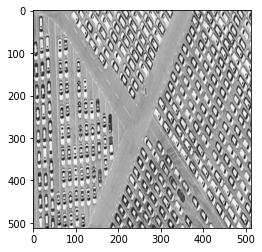

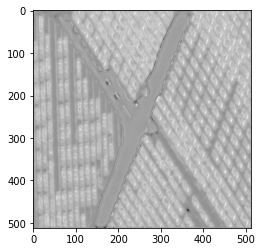

<Figure size 432x288 with 0 Axes>

In [ ]:
from sklearn.preprocessing import MinMaxScaler

model.load_state_dict(best_model_wts)
model.eval()
model = model.cuda()

for inputs in testloader:

    #print(dataloaders['train'])
    #inputs['image'] = inputs['image'].to(device)
    inputs = inputs.to(device)
    
    #print(inputs['image'].shape)
    #inputs['segmented_mask'] =  inputs['segmented_mask'].to(device)


    

    outputs = model(inputs)

    output_image = outputs.cpu().data.numpy()[0,0,:,:].reshape(512,512)

    #output_image *= 1.0/output_image.max()

    print(output_image.min())
    print(output_image.max())


    
    plt.figure(1)
    plt.imshow(inputs.cpu().numpy()[0,0,:,:].reshape(512,512),cmap='gray')
    #plt.figure(2)
    #plt.imshow(inputs['segmented_mask'].cpu().numpy()[0,:,:,:].reshape(512,512),cmap='gray')
    plt.figure(2)
    plt.imshow(outputs.cpu().data.numpy()[0,0,:,:].reshape(512,512),cmap='gray')
    plt.figure(3)
    plt.imshow(output_image_tr,cmap='gray')    

    print(ok)


    #loss = calc_loss(outputs, inputs['segmented_mask'], metrics)
    #epoch_samples += inputs['image'].size(0)
#plt.show()

In [ ]:
from google.colab.patches import cv2_imshow

input_img = inputs.cpu().numpy()[0,0,:,:].reshape(512,512)

slice1Copy = np.uint8(output_image)

edges= cv2.Canny(slice1Copy,0.02,0.8)

contours, hierarchy= cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

#cv2.drawContours(inputs.cpu().numpy()[0,0,:,:].reshape(512,512), contours, -1, (0,255,0),1)



input_img_bgr= cv2.cvtColor(input_img, cv2.COLOR_GRAY2BGR)  #add this line

cv2.drawContours(input_img_bgr, contours, -1, (0,255,0), 1)  # I am expecting the contour lines to be green
cv2_imshow(input_img_bgr)
#plt.imshow(edges)


In [ ]:
#model_trained = train_model(model, optimizer, exp_lr_scheduler, num_epochs=50)


In [ ]:
import cv2
import numpy as np

# read and scale down image
# wget https://bigsnarf.files.wordpress.com/2017/05/hammer.png #black and white
# wget https://i1.wp.com/images.hgmsites.net/hug/2011-volvo-s60_100323431_h.jpg
#img = cv2.pyrDown(cv2.imread('2011-volvo-s60_100323431_h.jpg', cv2.IMREAD_UNCHANGED))

# threshold image
#ret, threshed_img = cv2.threshold(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY),
#                127, 255, cv2.THRESH_BINARY)
# find contours and get the external one

contours, hier = cv2.findContours(output_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

#image, contours, hier = cv2.findContours(threshed_img, cv2.RETR_TREE,
#                cv2.CHAIN_APPROX_SIMPLE)

# with each contour, draw boundingRect in green
# a minAreaRect in red and
# a minEnclosingCircle in blue
for c in contours:
    # get the bounding rect
    x, y, w, h = cv2.boundingRect(c)
    # draw a green rectangle to visualize the bounding rect
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)

    # get the min area rect
    rect = cv2.minAreaRect(c)
    box = cv2.boxPoints(rect)
    # convert all coordinates floating point values to int
    box = np.int0(box)
    # draw a red 'nghien' rectangle
    cv2.drawContours(img, [box], 0, (0, 0, 255))

    # finally, get the min enclosing circle
    (x, y), radius = cv2.minEnclosingCircle(c)
    # convert all values to int
    center = (int(x), int(y))
    radius = int(radius)
    # and draw the circle in blue
    img = cv2.circle(img, center, radius, (255, 0, 0), 2)

print(len(contours))
cv2.drawContours(img, contours, -1, (255, 255, 0), 1)

cv2.imshow("contours", img)

cv2.imshow("contours", img)

while True:
    key = cv2.waitKey(1)
    if key == 27: #ESC key to break
        break

cv2.destroyAllWindows()